In [1]:
# import matplotlib.pyplot as plot
import pandas as pd
import os
os.environ["DGLBACKEND"] = "pytorch"
import dgl
import torch
from dgl.data import DGLDataset
import numpy as np
import torch.nn as nn
import torch
import itertools
import dgl.data
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from tqdm import tqdm
import matplotlib.pyplot as plot

/hpc/group/vossenlab/rck32/ML_venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
num_dfs = 1000
dfs = []
for i in range(num_dfs):
    try:
        new_df = pd.read_csv(f"/hpc/group/vossenlab/rck32/eic/work_eic/macros/Timing_estimation/data/df/jan_18_50events_{i}.csv")
    except FileNotFoundError as e:
        print(f"skipping file #{i}...")
        continue
    #use file_idx to differentiate rows that have same event_idx but originate from diff files
    new_df["file_idx"] = i
    dfs.append(new_df)
data = pd.concat(dfs)

skipping file #110...
skipping file #128...
skipping file #238...
skipping file #403...
skipping file #469...
skipping file #505...
skipping file #535...
skipping file #561...
skipping file #590...
skipping file #601...
skipping file #648...
skipping file #684...
skipping file #685...
skipping file #748...
skipping file #760...
skipping file #774...
skipping file #776...
skipping file #786...
skipping file #840...
skipping file #872...
skipping file #894...
skipping file #928...
skipping file #929...
skipping file #963...
skipping file #989...


In [3]:
def process_df_vectorized(df, cone_angle_deg=45):
    # Grab positions to use as center of cone
    event_references = (
        df.groupby(['event_idx', 'file_idx'])
        .last()[['first_hit_strip_x', 'first_hit_strip_y']]
        .reset_index()
    )
    #Save angle of center/reference
    event_references['reference_angle'] = np.degrees(
        np.arctan2(event_references['first_hit_strip_y'],event_references['first_hit_strip_x'])
    )
    
    # Add these new columns to original df
    df = df.merge(event_references[['event_idx', 'file_idx', 'reference_angle']], 
                  on=['event_idx', 'file_idx'], how='left')
    
    # Calc angle of each hit and how far off from center
    df['hit_angle'] = np.degrees(np.arctan2(df['strip_y'] * 10, df['strip_x'] * 10))
    df['angle_diff'] = np.abs(df['hit_angle'] - df['reference_angle'])
    
    # Handle the wraparound at ±180 degrees
    df['angle_diff'] = np.minimum(df['angle_diff'], 360 - df['angle_diff'])
    
    # Label hits outside of the cone as noise (-1)
    df['ModifiedTrueID'] = df['trueID']
    df.loc[df['angle_diff'] > cone_angle_deg, 'ModifiedTrueID'] = -1
    
    # Drop intermediate columns if necessary
    return df
#     return df.drop(columns=['reference_angle', 'hit_angle', 'angle_diff'])


# Plot the data
modified_df = process_df_vectorized(data, cone_angle_deg = 22)

In [4]:
class HitDataset(DGLDataset):
    def __init__(self, data, filter_events,max_distance = 200):
        self.data = data
        self.filter_events = filter_events
        self.max_distance = max_distance
        super().__init__(name = "KLM_reco")
    def process(self):
        events_group = self.data.groupby(["event_idx","file_idx"])
#         self.labels = torch.empty(len(events_group))
        self.labels = []
        self.graphs = []
        it_idx = 0
        for event_idx in events_group.groups:
            curr_event = events_group.get_group(event_idx)
            nhits = len(curr_event)
            '''FIRST FILTER FOR EVENTS'''
            if(self.filter_events):
                ModifiedTrueID_unique = np.array(curr_event['ModifiedTrueID'].unique())
                valid_ModifiedTrueID_unique = ModifiedTrueID_unique[ModifiedTrueID_unique != -1]
                #skip events with multiple valid trueIDs
                if(len(valid_ModifiedTrueID_unique) > 1):
                    continue
            
                #skip events with no valid ModififiedTrueIDs
                if(len(valid_ModifiedTrueID_unique) == 0):
                    continue
            # Skip graphs with only 1 hit (or 0)
            if(nhits <2):
                continue;
            else:
                x = curr_event['strip_x'].values
                y = curr_event['strip_y'].values

                # Create coordinate matrices
                x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
                y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences

                # Compute distances in one go
                distances = np.sqrt(x_diff**2 + y_diff**2)

                # Create mask for valid edges (upper triangle only to avoid duplicates)
                upper_mask = (distances < self.max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)

                # Get edge indices for upper triangle
                src_upper, dst_upper = np.where(upper_mask)

                # Create the bidirectional edges
                sources = np.concatenate([src_upper, dst_upper])
                destinations = np.concatenate([dst_upper, src_upper])
            g = dgl.graph((sources, destinations), num_nodes=nhits)
            #Want to predict momentum/energy
            label = torch.tensor(curr_event["P"].to_numpy()[0])
            self.labels.append(label)
            '''FLATTENED VERSION'''
            #THIS VERSION KEEPS FEATURES IN ONE DIMENSION
            feats = np.stack((
                curr_event["strip_x"].to_numpy(),curr_event["strip_y"].to_numpy(),
                curr_event["Time"].to_numpy(),
                curr_event["Charge"].to_numpy()
            ),axis = -1)
#             feats = curr_event["Charge"].to_numpy()
            g.ndata["feat"] = torch.tensor(feats)#.unsqueeze(-1)
    

            #add graph to dataset
            self.graphs.append(g)
            it_idx += 1
        self.dim_nfeats = self.graphs[0].ndata["feat"].shape[1]
        self.labels = torch.tensor(self.labels, dtype = torch.float32)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [5]:
dataset = HitDataset(modified_df,True)
print("done")

done


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def create_fast_edge_lists(curr_event, max_distance):
    # Convert coordinates to numpy arrays for faster computation
    x = curr_event['strip_x'].values
    y = curr_event['strip_y'].values
    
    # Create coordinate matrices
    x_diff = x[:, np.newaxis] - x[np.newaxis, :]  # Creates a matrix of all x differences
    y_diff = y[:, np.newaxis] - y[np.newaxis, :]  # Creates a matrix of all y differences
    
    # Compute distances in one go
    distances = np.sqrt(x_diff**2 + y_diff**2)
    
    # Create mask for valid edges (upper triangle only to avoid duplicates)
    upper_mask = (distances < max_distance) & (np.triu(np.ones_like(distances), k=1) > 0)
    
    # Get edge indices for upper triangle
    src_upper, dst_upper = np.where(upper_mask)
    
    # Create the bidirectional edges
    sources = np.concatenate([src_upper, dst_upper])
    destinations = np.concatenate([dst_upper, src_upper])
    
    return sources, destinations


def visualize_detector_graph(curr_event, sources, destinations, max_edges=1000, figsize=(10, 10)):
    """
    Visualizes the detector hits and their connections.
    
    Parameters:
    curr_event (pd.DataFrame): DataFrame containing 'strip_x' and 'strip_y' columns
    sources (np.array): Array of source node indices
    destinations (np.array): Array of destination node indices
    max_edges (int): Maximum number of edges to plot to avoid overcrowding
    figsize (tuple): Figure size in inches
    """
    colors = curr_event['ModifiedTrueID'].apply(lambda x: 'red' if x == -1 else 'blue')
    sizes = curr_event['Charge'].apply(lambda x: x)
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot nodes (hits)
    plt.scatter(curr_event['strip_x'], curr_event['strip_y'], 
               c=colors, s=sizes * 1, alpha=0.4, label='Detector hits')
    
    # If there are too many edges, randomly sample them
    n_edges = len(sources)
    if n_edges > max_edges:
        idx = np.random.choice(n_edges, max_edges, replace=False)
        sources = sources[idx]
        destinations = destinations[idx]
    
    # Plot edges
    for src, dst in zip(sources, destinations):
        x1, y1 = curr_event.iloc[src][['strip_x', 'strip_y']]
        x2, y2 = curr_event.iloc[dst][['strip_x', 'strip_y']]
        plt.plot([x1, x2], [y1, y2], 'gray', alpha=0.1, linewidth=0.5)
    # Add reference angle and highlight region
    reference_angle = curr_event['reference_angle'].iloc[0]  # Assuming one reference angle per event
    radius = 250  # Radius of the detector
    
    # Calculate the coordinates for the line
    x_ref = radius * np.cos(np.radians(reference_angle))
    y_ref = radius * np.sin(np.radians(reference_angle))
#     plt.plot([0, x_ref], [0, y_ref], color='black', linewidth=3, label='Reference angle')
    
    # Highlight the 11-degree region
    theta_min = reference_angle - 22
    theta_max = reference_angle + 22
    
    # Calculate the coordinates for the line
    x_min = radius * np.cos(np.radians(theta_min))
    y_min = radius * np.sin(np.radians(theta_min))
    plt.plot([0, x_min], [0, y_min], color='orange', linewidth=1.5, label='Lower bound')
    
    # Calculate the coordinates for the line
    x_max = radius * np.cos(np.radians(theta_max))
    y_max = radius * np.sin(np.radians(theta_max))
    plt.plot([0, x_max], [0, y_max], color='orange', linewidth=1.5, label='Upper bound')
    
    # Add labels and title
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title(f'Detector Graph Visualization\n{len(curr_event)} nodes, {n_edges//2} edges')
    
    # Add text with statistics
    stats_text = f'Total nodes: {len(curr_event)}\n'
    stats_text += f'Total edges: {n_edges//2}\n'  # Divide by 2 because edges are bidirectional
    stats_text += f'Average degree: {n_edges/len(curr_event):.1f}'
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.tight_layout()
#     plt.xlim(120,250)
#     plt.ylim(25,130)
    plt.xlim(-250,250)
    plt.ylim(-250,250)
    plt.savefig("plots/GNN/graph_only.pdf")
    


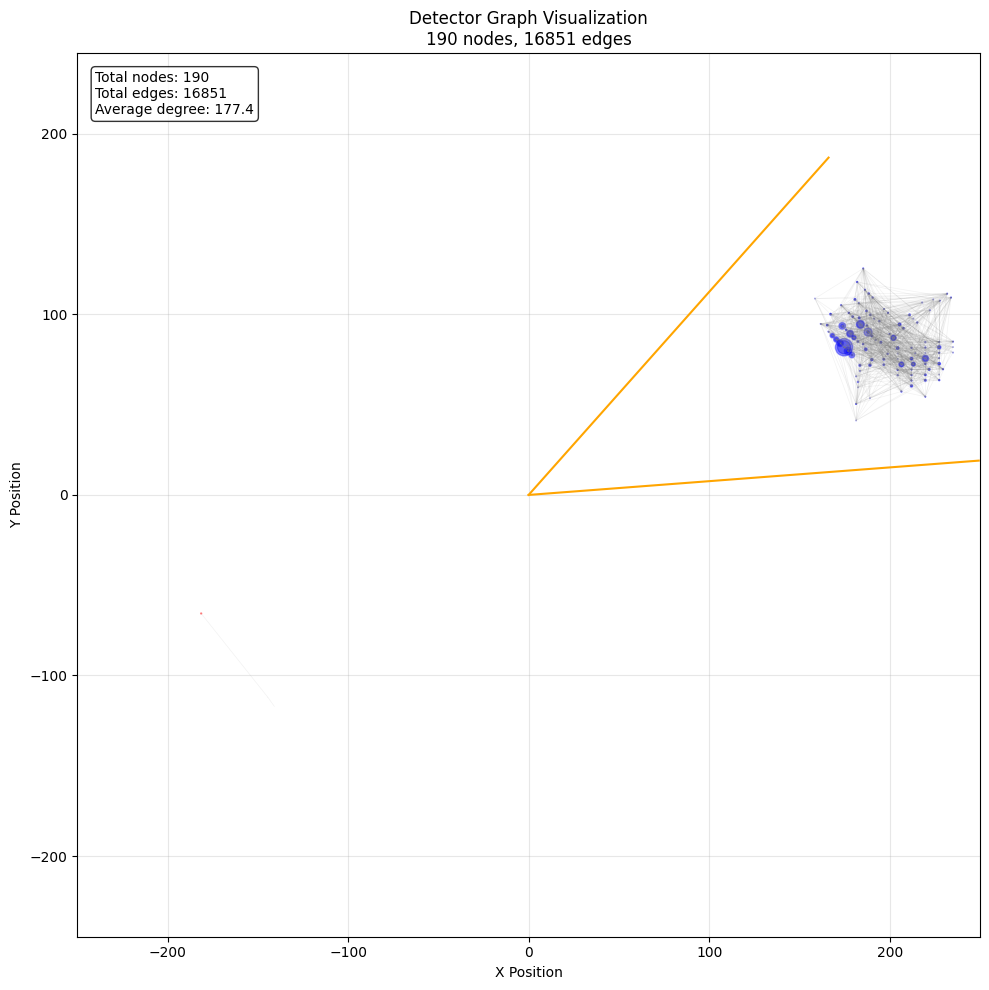

In [7]:
event_groups = modified_df.groupby(["event_idx","file_idx"])
event_1 = event_groups.get_group((8,0))
srcs, dests = create_fast_edge_lists(event_1,200)
visualize_detector_graph(event_1,srcs,dests)

In [8]:
from dgl.nn import GraphConv,SumPooling,GINConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes = 1):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats,allow_zero_in_degree = True)
        self.conv2 = GraphConv(h_feats, h_feats,allow_zero_in_degree = True)
        self.conv3 = GraphConv(h_feats, h_feats,allow_zero_in_degree = True)
        self.dropout = nn.Dropout(0.5)
        self.pool = SumPooling()
        self.fc = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv3(g, h)
        hg = self.pool(g,h)
        return self.fc(hg)
    
#GOOD VERSION:

class GIN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes=1):
        super(GIN, self).__init__()
        
        # Define the MLP for the GINConv layers
        self.mlp1 = nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        )
        
        self.mlp2 = nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, num_classes)
        )
        
        # Define the GINConv layers
        self.conv1 = GINConv(self.mlp1)
        self.conv2 = GINConv(self.mlp2)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.05)
        
        # Graph pooling layer
        self.pool = SumPooling()

    def forward(self, g, in_feat):
        # Apply the first GINConv layer
        h = self.conv1(g, in_feat)
        h = F.relu(h)
#         h = self.dropout(h)
        
        # Apply the second GINConv layer
        h = self.conv2(g, h)
        
        # Pool the graph-level representation
        hg = self.pool(g, h)
        
        return hg


In [19]:
from torch.utils.data.sampler import SubsetRandomSampler

train_frac = 0.8
num_train = int(np.floor(len(dataset) * train_frac))
num_examples = len(dataset)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=20, drop_last=False
)

test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=20, drop_last=False
)

In [20]:
# Create the model with given dimensions
# model = GCN(dataset.dim_nfeats, 6)
model = GIN(dataset.dim_nfeats, 6)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [21]:
test_graph = dataset[0][0]

In [22]:
# test_graph.ndata

In [23]:
# model(test_graph,test_graph.ndata["feat"].float())

In [24]:
n_epochs = 13
test_mse = []
test_mse_all = []
test_train_mse = []
test_train_mse_all = []
train_losses = []
train_losses_all = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    num_train_batches = 0
    epoch_train_losses = 0.0

    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["feat"].float())

        # Compute loss and update the model
        loss = criterion(pred, labels.unsqueeze(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses+=loss.detach()
        train_losses_all.append(loss.detach())
        num_train_batches += 1

    # Average RMSE for the epoch
    this_epoch_loss = epoch_train_losses / num_train_batches
    train_losses.append(this_epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {this_epoch_loss:.4f}")
    
    # Testing phase
    model.eval()
    epoch_test_mse = 0.0
    num_test_batches = 0

    with torch.no_grad():  # Disable gradients for evaluation
        for batched_graph, labels in test_dataloader:
            pred = model(batched_graph, batched_graph.ndata["feat"].float())
            # Calculate RMSE for this batch
            batch_mse = criterion(pred, labels.unsqueeze(-1))
            epoch_test_mse += batch_mse
            num_test_batches += 1
            test_mse_all.append(batch_mse)

    # Average RMSE for the test set
    epoch_test_mse /= num_test_batches
    test_mse.append(epoch_test_mse)
    print(f"Epoch {epoch + 1}/{n_epochs} - Test MSE: {epoch_test_mse:.4f}")
    
    ''''''
#     epoch_test_train_mse = 0.0
#     num_test_train_batches = 0

#     with torch.no_grad():  # Disable gradients for evaluation
#         for batched_graph, labels in train_dataloader:
#             pred = model(batched_graph, batched_graph.ndata["feat"].float())
#             # Calculate RMSE for this batch
#             batch_mse = criterion(pred, labels.unsqueeze(-1))
#             epoch_test_train_mse += batch_mse
#             num_test_train_batches += 1
#             test_train_mse_all.append(batch_mse)

#     # Average RMSE for the test set
#     epoch_test_train_mse /= num_test_train_batches
#     test_train_mse.append(epoch_test_train_mse)
#     print(f"Epoch {epoch + 1}/{n_epochs} - Train MSE: {epoch_test_train_mse:.4f}")

# Final RMSE results
print(f"Final Train RMSE:  {train_losses[-1]:.4f}")
print(f"Final Test RMSE: {test_mse[-1]:.4f}")


Epoch 1/13 - Train loss: 6203320041472.0000
Epoch 1/13 - Test MSE: 4180711936.0000
Epoch 2/13 - Train loss: 1568866304.0000
Epoch 2/13 - Test MSE: 428514336.0000
Epoch 3/13 - Train loss: 143714976.0000
Epoch 3/13 - Test MSE: 34833076.0000
Epoch 4/13 - Train loss: 14070557.0000
Epoch 4/13 - Test MSE: 6456362.5000
Epoch 5/13 - Train loss: 1487481.1250
Epoch 5/13 - Test MSE: 694532.5625
Epoch 6/13 - Train loss: 185964.3750
Epoch 6/13 - Test MSE: 96281.5391
Epoch 7/13 - Train loss: 29291.0234
Epoch 7/13 - Test MSE: 40477.4180
Epoch 8/13 - Train loss: 16676.1113
Epoch 8/13 - Test MSE: 25423.3770
Epoch 9/13 - Train loss: 9589.5420
Epoch 9/13 - Test MSE: 7133.0591
Epoch 10/13 - Train loss: 3165.3857
Epoch 10/13 - Test MSE: 73.7347
Epoch 11/13 - Train loss: 21.9209
Epoch 11/13 - Test MSE: 1.3411
Epoch 12/13 - Train loss: 0.5492
Epoch 12/13 - Test MSE: 0.4211
Epoch 13/13 - Train loss: 0.4281
Epoch 13/13 - Test MSE: 0.4216
Final Train RMSE:  0.4281
Final Test RMSE: 0.4216


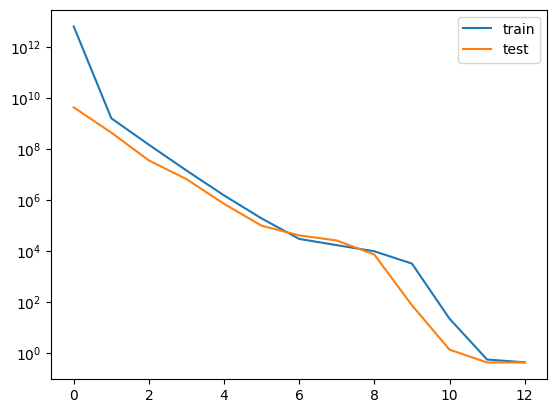

In [25]:
plot.plot(train_losses,label = "train")
plot.plot(test_mse, label = "test")
plot.yscale("log")
plot.legend()

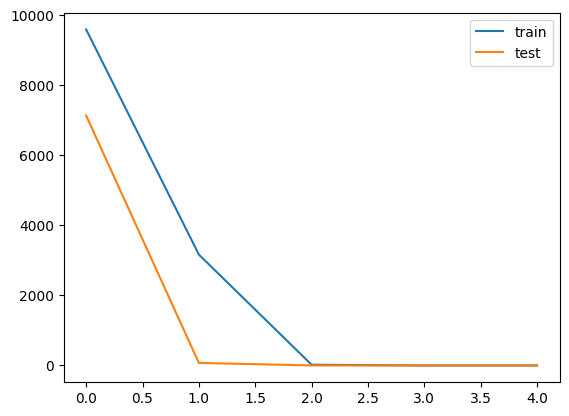

In [26]:
plot.plot(train_losses[8:],label = "train")
plot.plot(test_mse[8:], label = "test")
# plot.yscale("log")
plot.legend()

In [27]:
truths = []
preds = []
summed_sqe = 0.0
num_predictions = 0
with torch.no_grad():
    for batched_graph, labels in test_dataloader:
        graphs = dgl.unbatch(batched_graph)
        for i in range(len(graphs)):
            graph = graphs[i]
            label = labels[i].item()
            pred = model(graph, graph.ndata["feat"].float()).detach().numpy()
            summed_sqe += pow(pred - label,2)
            num_predictions += 1

            preds.append(pred)
            truths.append(label)
mse = summed_sqe / num_predictions
print(f"MSE: {mse[0][0]}")

MSE: 0.4215739965438843


Text(0, 0.5, 'preds')

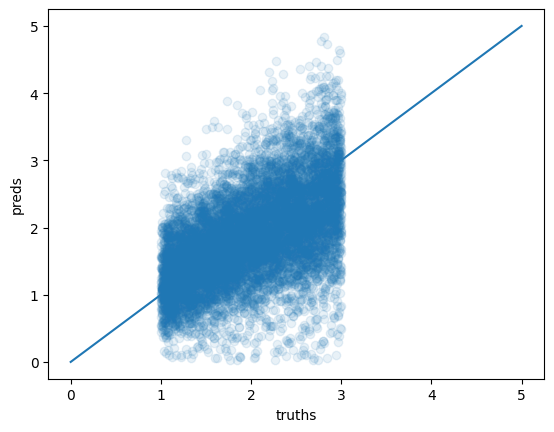

In [28]:
plot.plot([0,5],[0,5])
plot.scatter(truths,preds,alpha = 0.1)
plot.xlabel("truths")
plot.ylabel("preds")
# plot.xlim(0.5,3.5)
# plot.ylim(0.5,3.5)

## Past results

train, 10 epochs: 0.92
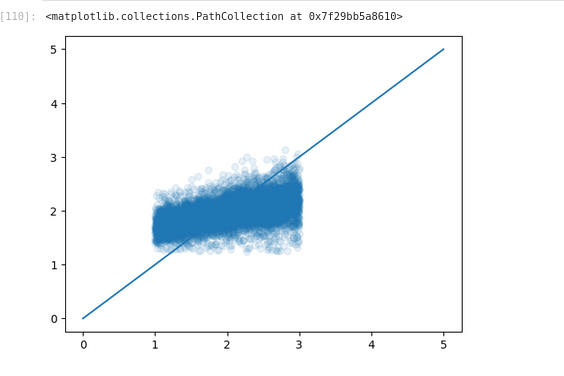

test, 2 epochs:
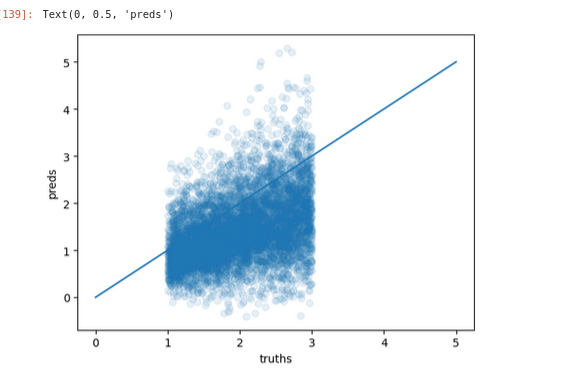

# Binned RMSE

In [29]:
def calculate_bin_rmse(test_dataloader, model, bin_width=0.5, bin_min=1.0, bin_max=3.0):
    # Calculate the bin centers
    bin_centers = np.arange(bin_min + bin_width / 2, bin_max, bin_width)
    
    # Initialize dictionaries to store squared errors and counts per bin
    summed_sqe_per_bin = {bin_center: 0.0 for bin_center in bin_centers}
    bin_counts = {bin_center: 0 for bin_center in bin_centers}
    
    # Initialize lists to store predictions and truths
    preds = []
    truths = []
    
    # Process each batch of test data
    with torch.no_grad():
        for batched_graph, labels in test_dataloader:
            graphs = dgl.unbatch(batched_graph)
            for i in range(len(graphs)):
                graph = graphs[i]
                label = labels[i].item()
                pred = model(graph, graph.ndata["feat"].float()).detach().numpy()

                # Store predictions and truths
                preds.append(pred)
                truths.append(label)
                
                # Calculate the squared error
                squared_error = (pred - label) ** 2
                
                # Find the bin this label falls into and update corresponding squared error and count
                for bin_center in bin_centers:
                    bin_min_edge = bin_center - bin_width / 2
                    bin_max_edge = bin_center + bin_width / 2
                    if bin_min_edge <= label < bin_max_edge:
                        summed_sqe_per_bin[bin_center] += squared_error
                        bin_counts[bin_center] += 1
                        break  # Only assign to one bin
    
    # Calculate RMSE for each bin
    rmse_per_bin = {}
    for bin_center in bin_centers:
        if bin_counts[bin_center] > 0:  # Avoid division by zero if no predictions fall into the bin
            rmse_value = np.sqrt(summed_sqe_per_bin[bin_center] / bin_counts[bin_center])
            rmse_per_bin[bin_center] = float(rmse_value[0,0])  # Ensure it's a scalar
        else:
            rmse_per_bin[bin_center] = float('nan')  # Assign NaN if no predictions fall into the bin
    
    return rmse_per_bin
rmse_per_bin = calculate_bin_rmse(test_dataloader, model)

In [30]:
bin_centers = np.array(list(rmse_per_bin.keys()))
rmse = np.array(list(rmse_per_bin.values()))
rel_rmse = rmse / bin_centers

In [31]:
def func(x, A):
    return A / np.sqrt(x)
from scipy.optimize import curve_fit

params, cov = curve_fit(func, bin_centers, rel_rmse)
x_fit = np.linspace(1, 3, 100)
y_fit = func(x_fit, params)

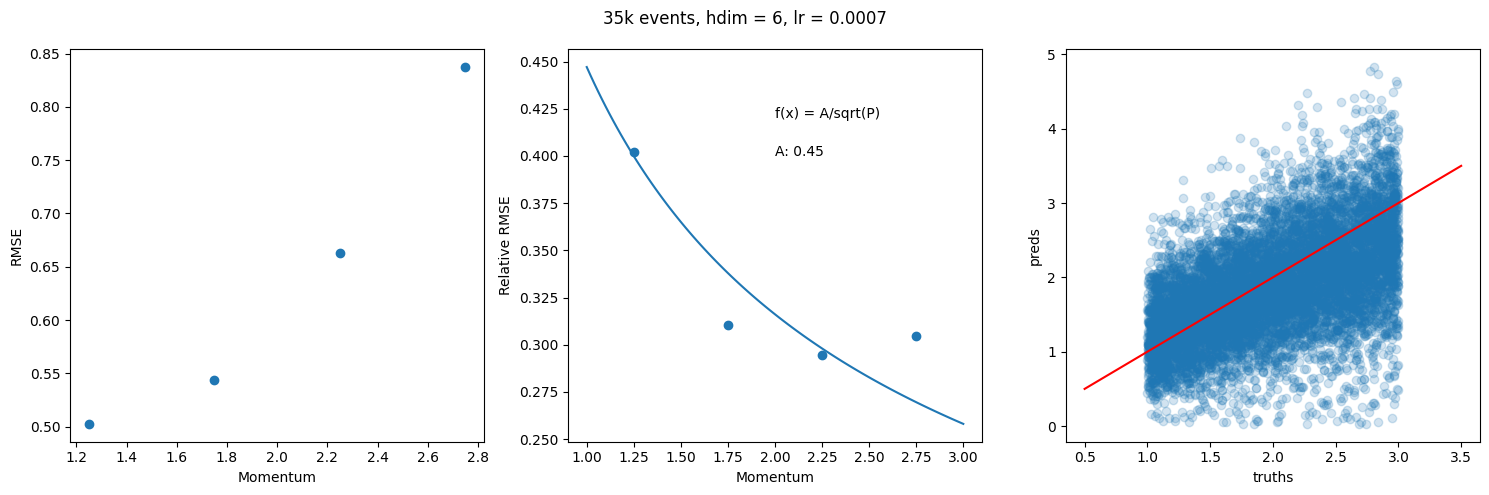

In [33]:
fig,axs = plot.subplots(1,3,figsize = (15,5))
fig.suptitle("35k events, hdim = 6, lr = 0.0007")
axs[0].scatter(rmse_per_bin.keys(),rmse_per_bin.values())
axs[0].set(xlabel="Momentum",ylabel = "RMSE")
axs[1].scatter(rmse_per_bin.keys(),np.array(list(rmse_per_bin.values())) / np.array(list(rmse_per_bin.keys())))
axs[1].plot(x_fit,y_fit)
axs[1].set(xlabel="Momentum",ylabel = "Relative RMSE")
axs[1].text(2,0.4,f"A: {params[0]:.2f}")
axs[1].text(2,0.42,f"f(x) = A/sqrt(P)")
axs[2].scatter(truths,preds,alpha = 0.2)
axs[2].plot([0.5,3.5],[0.5,3.5],color = "red")
axs[2].set(xlabel = "truths",ylabel = "preds")
fig.tight_layout()
plot.savefig("plots/GNN/RMSE_50kevents_hdim6_lr0_001_epochs13_GIN.pdf")

0.45